In [55]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_file_path = 'lab2_train.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')

# This should be used for predictions!!

#test_file_path = '../../lab2_test.csv'
#test_data = pd.read_csv(test_file_path, delimiter=',')

       user_from_id  user_to_id  is_like is_match
0              1136        3141    False    False
1              2424        3174    False    False
2              1300        3590    False    False
3               800        2736    False    False
4               883         437    False    False
...             ...         ...      ...      ...
76387          2376        3057    False    False
76388          1163         933    False    False
76389          2770        3324    False    False
76390           879         785    False    False
76391           291         470    False    False

[76392 rows x 4 columns]


## Data Familiarization

#### Missing values are mapped to zero and will be seen as the background color on the heatmap.

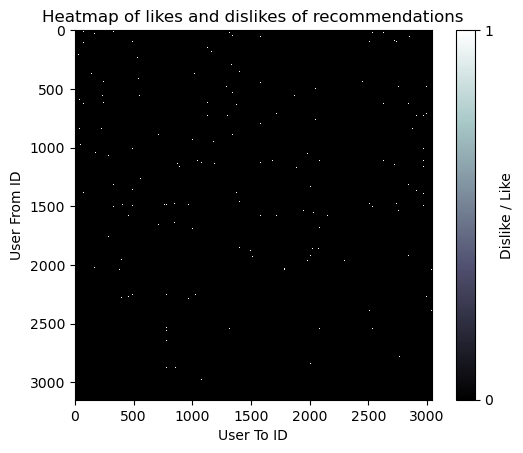

In [27]:
# Create a pivot table for the heatmap
heatmap_data = pd.pivot_table(train_data, values='is_like', index='user_from_id', columns='user_to_id', fill_value=0)

# Map True to 1 and False to 0 (if needed)
heatmap_data = heatmap_data.astype(int)

# Plot the heatmap with white for True and blue for False
plt.imshow(heatmap_data, cmap='bone', interpolation='nearest', vmin=0, vmax=1)

# Set colorbar ticks and labels
plt.colorbar(ticks=[0, 1], label='Dislike / Like')

plt.xlabel('User To ID')
plt.ylabel('User From ID')
plt.title('Heatmap of likes and dislikes of recommendations')

plt.show()

#### We can see that there's far more dislikes than likes in the training data.

### Number of users of the app within our training data

In [28]:
num_of_users = set(pd.concat([train_data['user_from_id'], train_data['user_to_id']]).tolist())
print("The total number of users in the training data is", len(num_of_users))
print("The highest user ID is", max(num_of_users))

The total number of users in the training data is 3591
The highest user ID is 3716


#### After inspecting the training data manually, we found that users with lower IDs appear more often. This suggests that IDs are assigned increasingly. So we can label users as new and veterans.

### Data Sparsity

In [29]:
rows_with_missing_user_from_id = train_data[train_data['user_from_id'].isna()]
rows_with_missing_user_to_id = train_data[train_data['user_to_id'].isna()]
rows_with_missing_is_like = train_data[train_data['is_like'].isna()]
rows_with_missing_is_match = train_data[train_data['is_match'].isna()]
total_rows_missing_values = len(rows_with_missing_user_from_id) + len(rows_with_missing_user_to_id) + len(rows_with_missing_is_like) + len(rows_with_missing_is_match)
print("#rows with missing values:", total_rows_missing_values)
print("#rows with missing is_match value:", len(rows_with_missing_is_match))
print("%.2f" % (total_rows_missing_values/len(train_data) * 100), "% of the training data is incomplete")

#rows with missing values: 815
#rows with missing is_match value: 815
1.07 % of the training data is incomplete


#### Now, let's build a matrix to illustrate the limited information available on users, highlighting the sparsity of the data. In general, data is deemed sparse when a significant portion, often around 50% or more, contains missing values.

In [30]:
X = pd.pivot_table(train_data, values='is_like', index='user_from_id', columns='user_to_id', fill_value=None)
print(X)
print("%.2f" % (X.isna().sum().sum() / (len(X) * len(X[0])) * 100), "% of the data is missing, so we consider it sparse")

user_to_id    0     1     2     3     4     5     6     7     8     9     ...  \
user_from_id                                                              ...   
1              NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2              0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3              NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4              0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5              NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3709           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3713           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3714           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3715           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3716           NaN   NaN   N

### Important properties of the data:
#### There are missing values specifically in the 'is_match' column of the data. To address this, we will exclude those rows from our analysis. 
#### Furthermore, by examining the heatmap, we observe variations in the frequency of users being liked when recommended to others. Some users receive likes frequently, while others receive none at all. This observation is intriguing, so let's inspect it further.

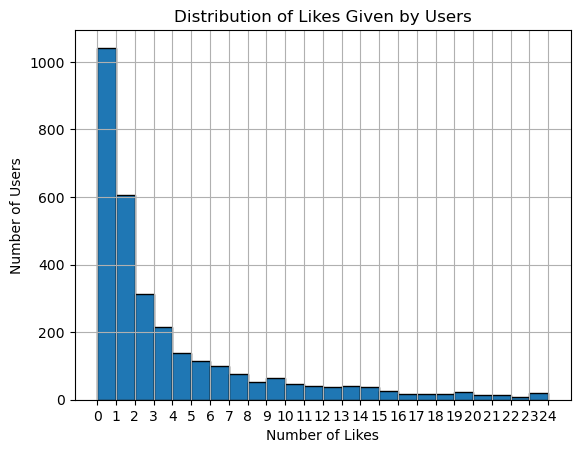

In [31]:
# Count the number of likes for each user
likes_per_user = train_data.groupby('user_from_id')['is_like'].sum()

# Create bins for the histogram
bins = range(25)  # Bins 0, 1, 2, ..., 25

# Create a histogram
plt.hist(likes_per_user, bins=bins, edgecolor='black')

# Customize the plot
plt.title('Distribution of Likes Given by Users')
plt.xlabel('Number of Likes')
plt.ylabel('Number of Users')
plt.grid(True)

# Set x-axis ticks to represent each bin
plt.xticks(range(25))

# Show the plot
plt.show()

### Based on this histogram we can tell picky people apart from those who find a lot of people attractive.

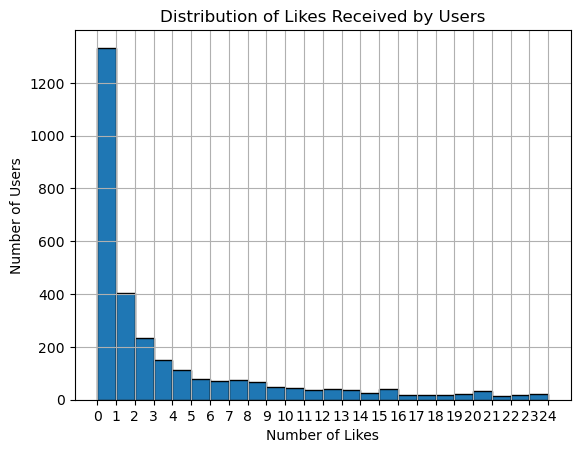

In [32]:
# Count the number of likes for each user
likes_per_user = train_data.groupby('user_to_id')['is_like'].sum()

# Create bins for the histogram
bins = range(25)  # Bins 0, 1, 2, ..., 25

# Create a histogram
plt.hist(likes_per_user, bins=bins, edgecolor='black')

# Customize the plot
plt.title('Distribution of Likes Received by Users')
plt.xlabel('Number of Likes')
plt.ylabel('Number of Users')
plt.grid(True)

# Set x-axis ticks to represent each bin
plt.xticks(range(25))

# Show the plot
plt.show()

### Based on this histogram we can tell popular/attractive people apart from those less popular/with great peronalities.

## NMF-based recommender system

### Firstly, we remove the outliers which are going to be the users who have given just likes or dislikes, because they don't really have a type, therefore they don't help us with recommendations.

In [33]:
# Creating the user by user matrix X
X = pd.pivot_table(train_data, values='is_like', index='user_from_id', columns='user_to_id', fill_value=None)

rows_to_keep = []

for i in range(len(X)):
    row_without_nans = X.iloc[i].dropna()
    if not ((row_without_nans == 0).all() or (row_without_nans == 1).all()):
        rows_to_keep.append(X.iloc[i])

X_new = pd.DataFrame(rows_to_keep)

user_to_id  0     1     2     3     4     5     6     7     8     9     ...  \
1            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2            0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4            0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
3597         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3624         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3626         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3635         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3689         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

user_to_id  3614  3615  3616  3618  3619  3620  362

### Since we noticed that the latter indices belong to newer users, we shuffle the data to ensure that the training and test sets are representative of the overall dataset and put 90% of the shuffeled data into the training set and the remaining 10% into the testing set.

In [34]:
# Convert the DataFrame to a NumPy array
X_np = X_new.to_numpy()

# Shuffle the data
np.random.seed(42)  # Set a random seed for reproducibility
shuffled_indices = np.random.permutation(len(X_np))

# Define the size of the training set (90% of the total data)
train_size = int(len(X_np) * 0.9)

# Split the indices into training and testing sets
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

# Create the training and testing sets
X_train = pd.DataFrame(X_np[train_indices], columns=X_new.columns)
X_test = pd.DataFrame(X_np[test_indices], columns=X_new.columns)

### Now we define the nmf routine, using a mask to handle NaNs.

In [65]:
def nmf(X: pd.DataFrame, n_components: int, max_iter: int=100, tol: float=1e-5):
    # Convert DataFrame to NumPy array (keep NaNs)
    X_np = X.to_numpy()

    # Create a mask for NaNs
    mask = ~np.isnan(X_np)

    # Initialize W and H with random non-negative values
    W = np.random.rand(X_np.shape[0], n_components)
    H = np.random.rand(n_components, X_np.shape[1])

    # Iteratively update W and H
    for i in range(max_iter):
        WH = np.matmul(W, H)

        # Update H
        numeratorH = np.matmul(W.T, np.nan_to_num(X_np * mask))
        denominatorH = np.matmul(W.T, WH) + 1e-9
        H *= numeratorH / denominatorH

        # Update W
        numeratorW = np.matmul(np.nan_to_num(X_np * mask), H.T)
        denominatorW = np.matmul(W, np.matmul(H, H.T)) + 1e-9
        W *= numeratorW / denominatorW

        # Calculate the error only on the non-NaN entries
        Enew = np.linalg.norm((np.nan_to_num(X_np) - WH) * mask) ** 2
        if Enew < tol:
            break

    return W, H

[[0.00000000e+00 0.00000000e+00 4.95325275e-04 ... 0.00000000e+00
  2.20315479e-07 4.76181009e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.52916516e-05 ... 0.00000000e+00
  1.05672950e-10 3.06291915e-12]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.58515675e-03 ... 0.00000000e+00
  2.75139382e-08 7.97488554e-10]
 [0.00000000e+00 0.00000000e+00 2.88961787e-07 ... 0.00000000e+00
  1.20733296e-12 3.49944165e-14]]
9845.211007972879


### Determining the Prediction Threshold from Reconstructed Ratings

#### To transform the ratings in the reconstructed matrix from our NMF model into binary predictions (1 for 'like' and 0 for 'dislike'), we need to establish a suitable threshold. This threshold serves as a decision boundary: ratings above it are rounded up to 1, and ratings below it are rounded down to 0. 

#### The `find_threshold_based_on_quantile` function is designed to compute this threshold based on the distribution of reconstructed ratings. By choosing a specific quantile, we can tailor our predictions to the density of the ratings. For instance, setting the threshold at the 90th percentile means we predict a 'like' only for the top 10% of ratings, which can be useful in scenarios where likes are rare or when we want to be conservative in our prediction of likes.

In [66]:
def find_threshold_based_on_quantile(reconstructed_matrix, quantile):
    # Flatten the matrix to a 1D array
    flat_matrix = reconstructed_matrix.flatten()
    
    # Compute the quantile
    threshold = np.quantile(flat_matrix, quantile)
    
    return threshold

Threshold based on the 90.0th percentile: 0.00120292620270696


### Now we need a function to check the accuracy of our predictions, so we define one below.

In [73]:
def calculate_accuracy(X_test, predictions_df):
    correct_count = 0
    ratings_count = 0

    for index, row in X_test.iterrows():
        user_id = index  # Assuming user_id corresponds to the index in X_test
        for item_id in X_test.columns:
            actual_rating = row[item_id]
            if not np.isnan(actual_rating):
                # Access the predicted rating
                predicted_rating = predictions_df.at[user_id, item_id]

                # Compare predicted_rating with actual_rating
                if predicted_rating == actual_rating:
                    correct_count += 1
                ratings_count += 1

    # Calculate and return accuracy
    if ratings_count > 0:
        accuracy = correct_count / ratings_count
        return accuracy
    else:
        return None

0.6854264373805802


### Now we try to optimize the hyperparameters of our nmf routine and the threshold.

In [74]:
n_components_range = [10, 15, 20]
max_iter_range = [50, 100, 150]

# Store both quantile and threshold
threshold_info = []

# Define the quantiles to explore
quantiles_to_try = [0.85, 0.90, 0.95]

best_accuracy = 0
best_params = {'n_components': None, 'max_iter': None, 'quantile': None, 'threshold': None}

for n_components in n_components_range:
    for max_iter in max_iter_range:
        # Perform NMF with the current set of hyperparameters
        W, H = nmf(X_train, n_components=n_components, max_iter=max_iter)
        reconstructed_matrix = np.matmul(W, H)

        # Calculate thresholds for current quantiles
        for quantile in quantiles_to_try:
            threshold = find_threshold_based_on_quantile(reconstructed_matrix, quantile)
            threshold_info.append((quantile, threshold))

            # Binarize the matrix based on the current threshold
            binarized_matrix = np.where(reconstructed_matrix >= threshold, 1, 0)

            # Calculate accuracy
            accuracy = calculate_accuracy(X_test, pd.DataFrame(binarized_matrix, index=X_train.index, columns=X_train.columns))

            # Update best parameters if current accuracy is higher
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'n_components': n_components, 'max_iter': max_iter, 'quantile': quantile, 'threshold': threshold}

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

Best Accuracy: 0.7347576862949453
Best Hyperparameters: {'n_components': 10, 'max_iter': 50, 'quantile': 0.95, 'threshold': 0.006838987744773777}


### Out of the parameters that we chose to check the best combination is to have 10 components, 50 iterations and to base the treshold on the 0.95 quantile as it gives around 73% accuracy.